In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Cardetails.csv')

In [3]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500.0,Diesel,Individual,Manual,First Owner,NaN,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000.0,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000.0,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000.0,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000.0,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
df.isnull().sum()

name                0
year                0
selling_price       0
km_driven         813
fuel                0
seller_type         0
transmission        0
owner               0
mileage          1011
engine           1008
max_power         215
torque            222
seats             221
dtype: int64

In [6]:
df.shape

(8128, 13)

In [7]:
df.dtypes

name              object
year               int64
selling_price      int64
km_driven        float64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

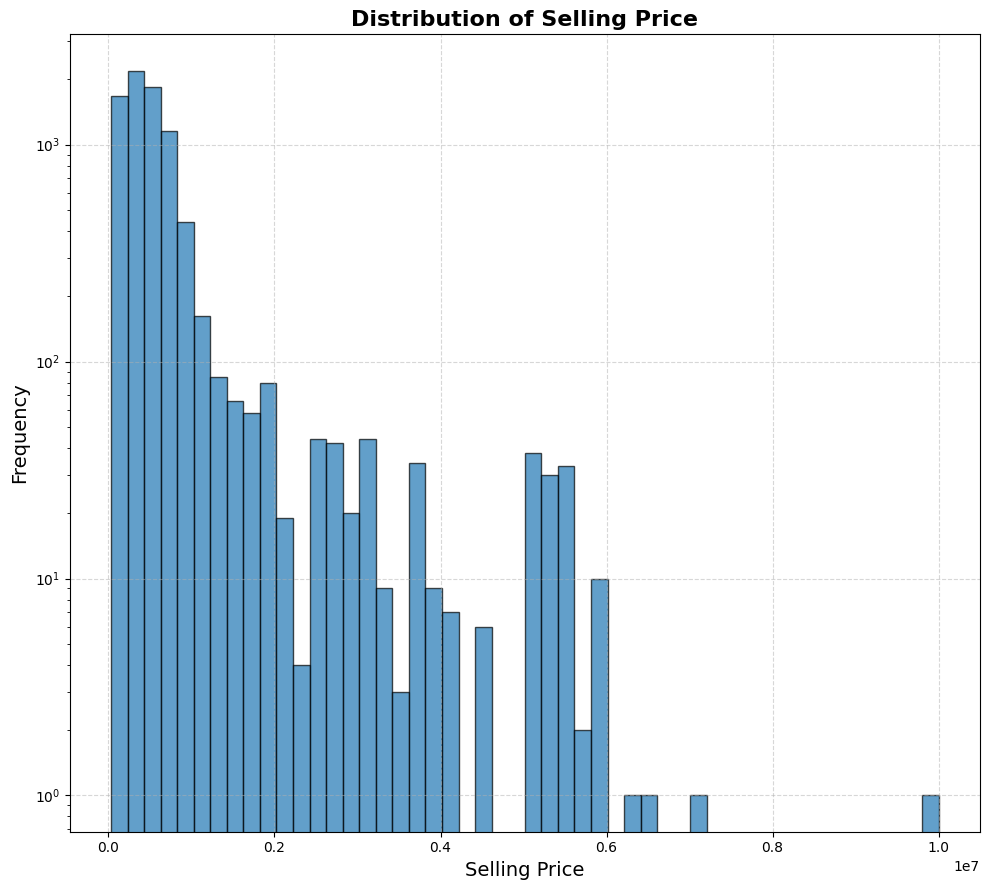

In [12]:
plt.figure(figsize=(10, 9))
plt.hist(df['selling_price'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Selling Price', fontsize=16, fontweight='bold')
plt.xlabel('Selling Price', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
if 'engine' in df.columns:
    df['engine'] = df['engine'].str.replace('CC', '', regex=False).str.strip()
    df['engine'] = pd.to_numeric(df['engine'], errors='coerce')
if 'max_power' in df.columns:
    df['max_power'] = df['max_power'].str.replace('bhp', '', regex=False).str.strip()
    df['max_power'] = pd.to_numeric(df['max_power'], errors='coerce')
if 'milage' in df.columns:
    df['mileage'] = df['mileage'].str.replace('Kmpl', '', regex=False).str.strip()
    df['mileage'] = pd.to_numeric(df['mileage'], errors='coerce')

In [16]:
y = df['selling_price']
X=df.drop(['name','torque','selling_price'], axis=1)

In [17]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [18]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

In [19]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [21]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [22]:
numerical_features = numerical_cols.tolist()
categorical_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
all_features = numerical_features + categorical_features

In [23]:
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_features, index=X_train.index)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_features, index=X_test.index)

In [25]:
rf_default = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,  
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

In [26]:
rf_default.fit(X_train_preprocessed_df, y_train)

# Make predictions
y_pred = rf_default.predict(X_test_preprocessed_df)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.0s finished


In [27]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nRandom Forest Model Performance:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Approximate Average Error: {mae/y_test.mean():.2%}")


Random Forest Model Performance:
MAE: $74296.09
MSE: $19894152781.97
RMSE: $141046.63
R² Score: 0.9696
Approximate Average Error: 11.67%


In [28]:
sample_prediction = rf_default.predict(X_test_preprocessed_df[:1])
print(f"\nSample prediction: ${sample_prediction[0]:.2f}")
print(f"Actual value: ${y_test.iloc[0]:.2f}")


Sample prediction: $194221.01
Actual value: $198000.00


[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.0s finished


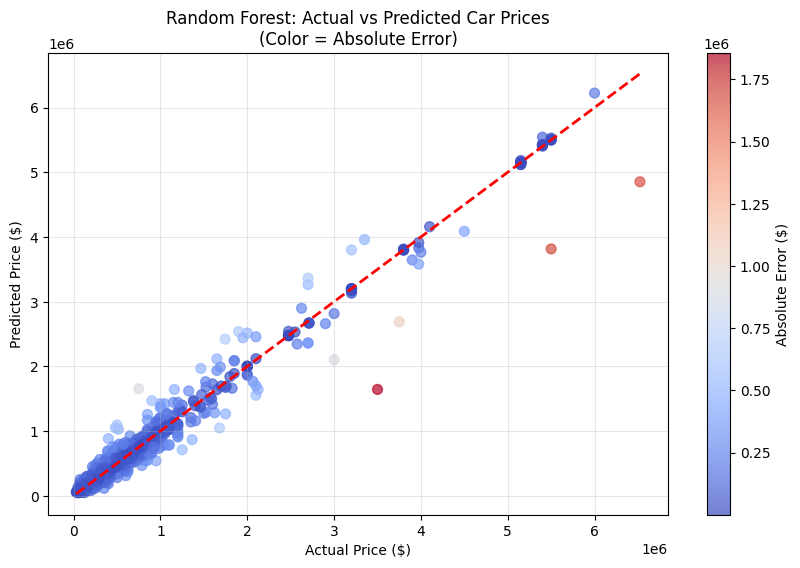

In [29]:
errors = np.abs(y_test - y_pred)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c=errors, cmap='coolwarm', alpha=0.7, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.colorbar(label='Absolute Error ($)')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Random Forest: Actual vs Predicted Car Prices\n(Color = Absolute Error)')
plt.grid(True, alpha=0.3)
plt.show()